In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving updated_X_recommend.pkl to updated_X_recommend.pkl
Saving updated_X_test.pkl to updated_X_test.pkl
Saving updated_X_train.pkl to updated_X_train.pkl
Saving updated_y_test.pkl to updated_y_test.pkl
Saving updated_y_train.pkl to updated_y_train.pkl


In [5]:
## Load the training, testing and eval data
# Load the data
X_train = pd.read_pickle('updated_X_train.pkl')
y_train = pd.read_pickle('updated_y_train.pkl')
X_test = pd.read_pickle('updated_X_test.pkl')
y_test = pd.read_pickle('updated_y_test.pkl')
X_recommend = pd.read_pickle('updated_X_recommend.pkl')

In [6]:
X_train.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,genre_modern indie pop,genre_modern rock,genre_nashville indie,genre_new romantic,genre_nz folk,genre_permanent wave,genre_pop,genre_pop punk,genre_pop rock,genre_shimmer pop
5430,175093.0,0.143,0.2690,10.0,-17.614,1.0,0.0351,0.290,0.859000,0.152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1349,141062.0,0.106,0.0202,8.0,-32.719,1.0,0.0430,0.799,0.769000,0.109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1754,210253.0,0.417,0.6890,2.0,-8.302,0.0,0.1780,0.575,0.000000,0.496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7103,333329.0,0.499,0.5830,9.0,-6.628,0.0,0.2100,0.227,0.000000,0.103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4726,168854.0,0.828,0.3330,4.0,-10.351,0.0,0.0332,0.732,0.000526,0.117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalize the Data with Min-Max Normalization

Since K-Nearest Neighbours is a distance based algorithm which is sensitive to range of features. Features that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus all input features are normalized to the range [0,1]

In [7]:
# Normalize features to [0,1]
minmax_scaler = MinMaxScaler()
X_train = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X_train.columns)

In [8]:
X_train.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,genre_modern indie pop,genre_modern rock,genre_nashville indie,genre_new romantic,genre_nz folk,genre_permanent wave,genre_pop,genre_pop punk,genre_pop rock,genre_shimmer pop
0,0.044912,0.148187,0.268478,0.909091,0.608825,1.0,0.036449,0.291164,0.862450,0.137400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.035560,0.109845,0.019160,0.727273,0.258783,1.0,0.044652,0.802209,0.772088,0.093243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.054573,0.432124,0.689354,0.181818,0.824620,0.0,0.184839,0.577309,0.000000,0.490655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.088393,0.517098,0.583133,0.818182,0.863413,0.0,0.218069,0.227911,0.000000,0.087082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.043197,0.858031,0.332612,0.363636,0.777137,0.0,0.034476,0.734939,0.000528,0.101458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Hyperparameter Tuning
We will tune for:
- Number of neighbours (n_neighbors)
- Leaf size (leaf_size)
- Power parameter (p)

In [9]:
# Check accuracy for each value for each hyperparameter in its range
# We will use GridSearchCV to automate this process

n_neighbors = list(range(1,30))
leaf_size = list(range(1,30))
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

print(hyperparameters)

{'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'p': [1, 2]}


In [10]:
# estimator = ML model to be tested
# param_grid = dictionary of hyperparameters to be tested
# n_jobs = number of cores to be used in parallel, -1 means use all
# cv = number of cross validation set elements
# verbose = setting it to 2 will print updates to the terminal

best_model = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 1682 candidates, totalling 16820 fits


KeyboardInterrupt: 

In [12]:
n_neighbors = best_model.best_estimator_.get_params()['n_neighbors']
leaf_size = best_model.best_estimator_.get_params()['leaf_size']
p = best_model.best_estimator_.get_params()['p']

print(f'Best n_neighbors: {n_neighbors}')
print(f'Best leaf_size: {leaf_size}')
print(f'Best p: {p}')

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

#### So I don't have to rerun the gridsearch each time:
Best n_neighbors: 4
Best leaf_size: 1
Best p: 1

## Model

In [13]:
n_neighbors = 4
leaf_size = 1
p = 1

In [14]:
# model
k_nearest_neighbours = KNeighborsClassifier(n_neighbors=n_neighbors,
                                           leaf_size=leaf_size,
                                           p=p)

# fit the model
k_nearest_neighbours.fit(X_train, y_train)

# prediction
predictions = k_nearest_neighbours.predict(X_test)

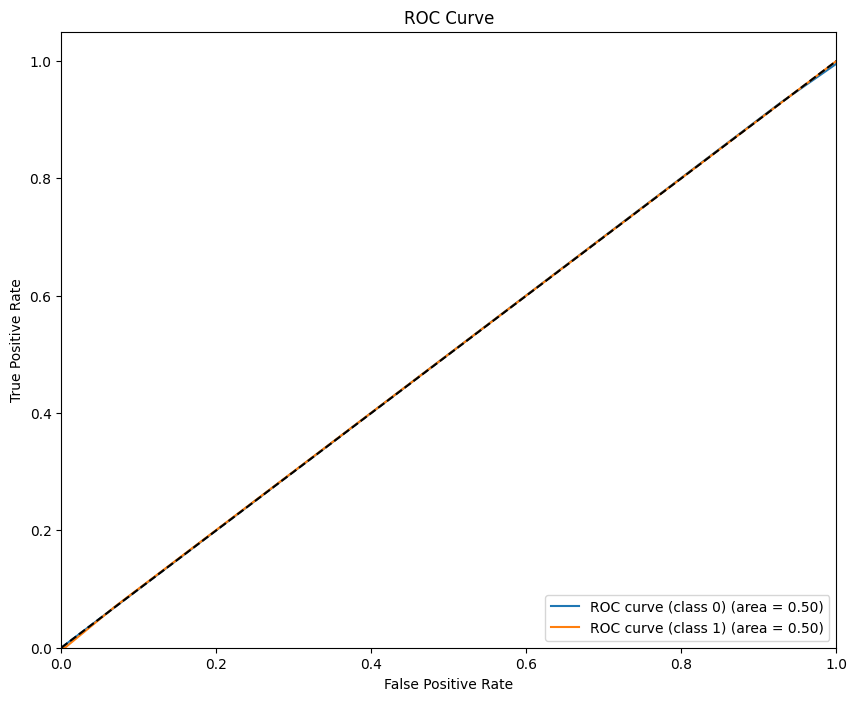

In [15]:
# Get predicted probabilities for each class
probabilities = k_nearest_neighbours.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(k_nearest_neighbours.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(k_nearest_neighbours.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

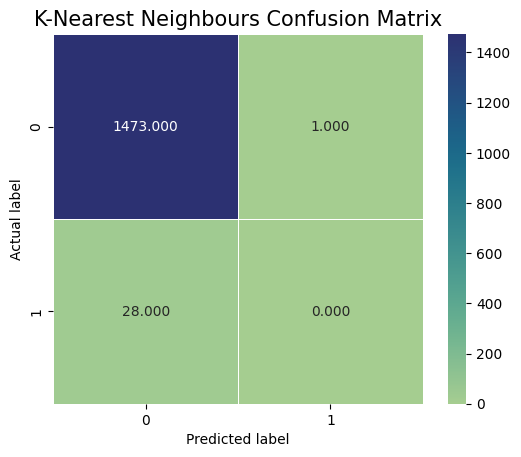

In [16]:
cm = confusion_matrix(y_test, predictions)
plt.figure()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'crest');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('K-Nearest Neighbours Confusion Matrix', size = 15);
plt.show()

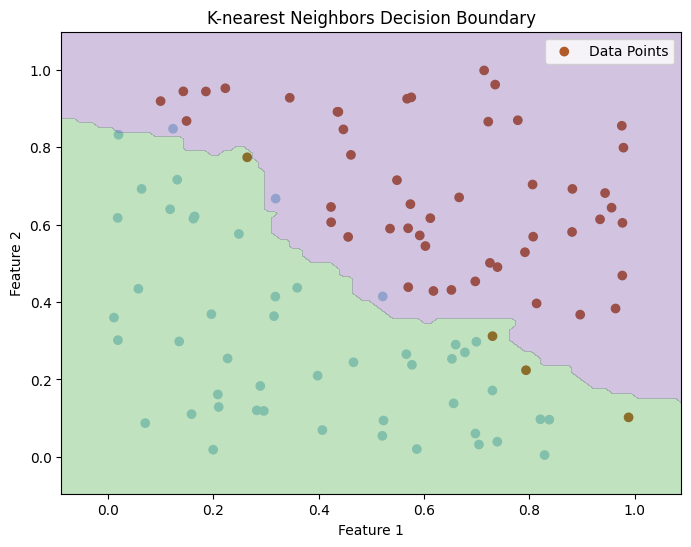

In [17]:
# Generate some synthetic data for demonstration
np.random.seed(0)
X = np.random.rand(100, 2)  # 100 samples with 2 features
y = (X[:, 0] + X[:, 1] > 1).astype(int)  # A simple linear decision boundary

# Fit the K-nearest neighbors classifier
k_nearest_neighbours = KNeighborsClassifier(n_neighbors=5)
k_nearest_neighbours.fit(X, y)

# Plot the decision boundary along with the data points
plt.figure(figsize=(8, 6))

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, label='Data Points')

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = k_nearest_neighbours.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired, levels=[-0.5, 0.5, 1.5])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-nearest Neighbors Decision Boundary')
plt.legend()
plt.show()

In [18]:
precision_macro_average = precision_score(y_test, predictions, average='macro')
precision_weighted_average = precision_score(y_test, predictions, average='weighted')

recall_macro_average = recall_score(y_test, predictions, average='macro')
recall_weighted_average = recall_score(y_test, predictions, average='weighted')

f1_macro_average = f1_score(y_test, predictions, average='macro')
f1_weighted_average = f1_score(y_test, predictions, average='weighted')


print(f'Precision (macro average)--> {round(precision_macro_average*100, 2)}%')
print(f'Precision (weighted average)--> {round(precision_weighted_average*100, 2)}%')

print(f'Recall (macro average)--> {round(recall_macro_average*100, 2)}%')
print(f'Recall (weighted average)--> {round(recall_weighted_average*100, 2)}%')

print(f'F1 score (macro average)--> {round(f1_macro_average*100, 2)}%')
print(f'F1 score (weighted average)--> {round(f1_weighted_average*100, 2)}%')

Precision (macro average)--> 49.07%
Precision (weighted average)--> 96.31%
Recall (macro average)--> 49.97%
Recall (weighted average)--> 98.07%
F1 score (macro average)--> 49.51%
F1 score (weighted average)--> 97.18%


In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1474
           1       0.00      0.00      0.00        28

    accuracy                           0.98      1502
   macro avg       0.49      0.50      0.50      1502
weighted avg       0.96      0.98      0.97      1502



In [20]:
# File path on Google Drive
file_path = "/content/drive/MyDrive/year 29/Data Science /notebooks/spotify/model/f1_scores.json"

# Serialize f1 scores into a json file for later comparison between all models
model_name = "updated_k_nearest_neighbours"
entry = {"f1_macro_average":f1_macro_average, "f1_weighted_average":f1_weighted_average}


with open(file_path, "r") as file:
    data = json.load(file)
data[model_name] = entry
with open(file_path, "w") as file:
    json.dump(data, file, indent=4)